In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import const as CONST
from utils import read_csv_ts
from darts import TimeSeries
import matplotlib
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
import seaborn as sns

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20, 10)
COLORS = [
    "red", "green", "blue", "purple", "cyan", "olive", "gray", "brown", "pink",
]

In [2]:
ds = load_datasets()

INFO:Dataset:Loading dataset from data/preprocessed/datasets_daily.pkl


In [3]:
print(f"Data starts: {ds.original.series[0].start_time()}")
print(f"Data ends: {ds.original.series[0].end_time()}, len = {len(ds.original.series[0])}")
print(f"Train data starts: {ds.original.train[0].start_time()}, len = {len(ds.original.train[0])}")
print(f"Validation data starts: {ds.original.val[0].start_time()}, len = {len(ds.original.val[0])}")
print(f"Test data starts: {ds.original.test[0].start_time()}, len = {len(ds.original.test[0])}")

Data starts: 2008-01-02 00:00:00
Data ends: 2023-03-10 00:00:00, len = 3824
Train data starts: 2008-01-02 00:00:00, len = 3059
Validation data starts: 2020-02-27 00:00:00, len = 382
Test data starts: 2021-09-01 00:00:00, len = 383


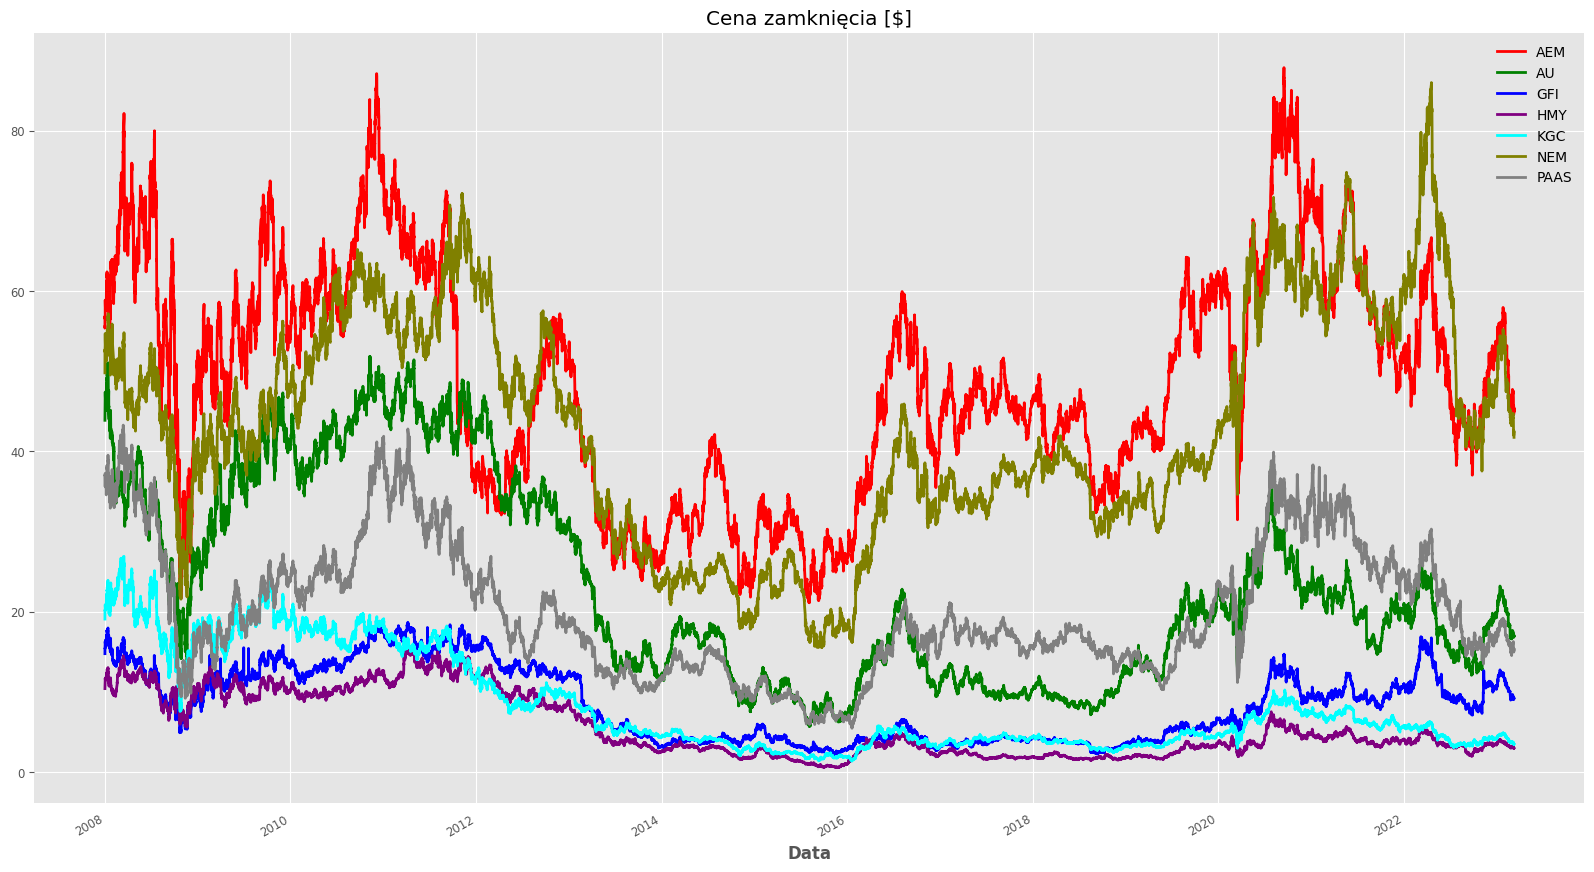

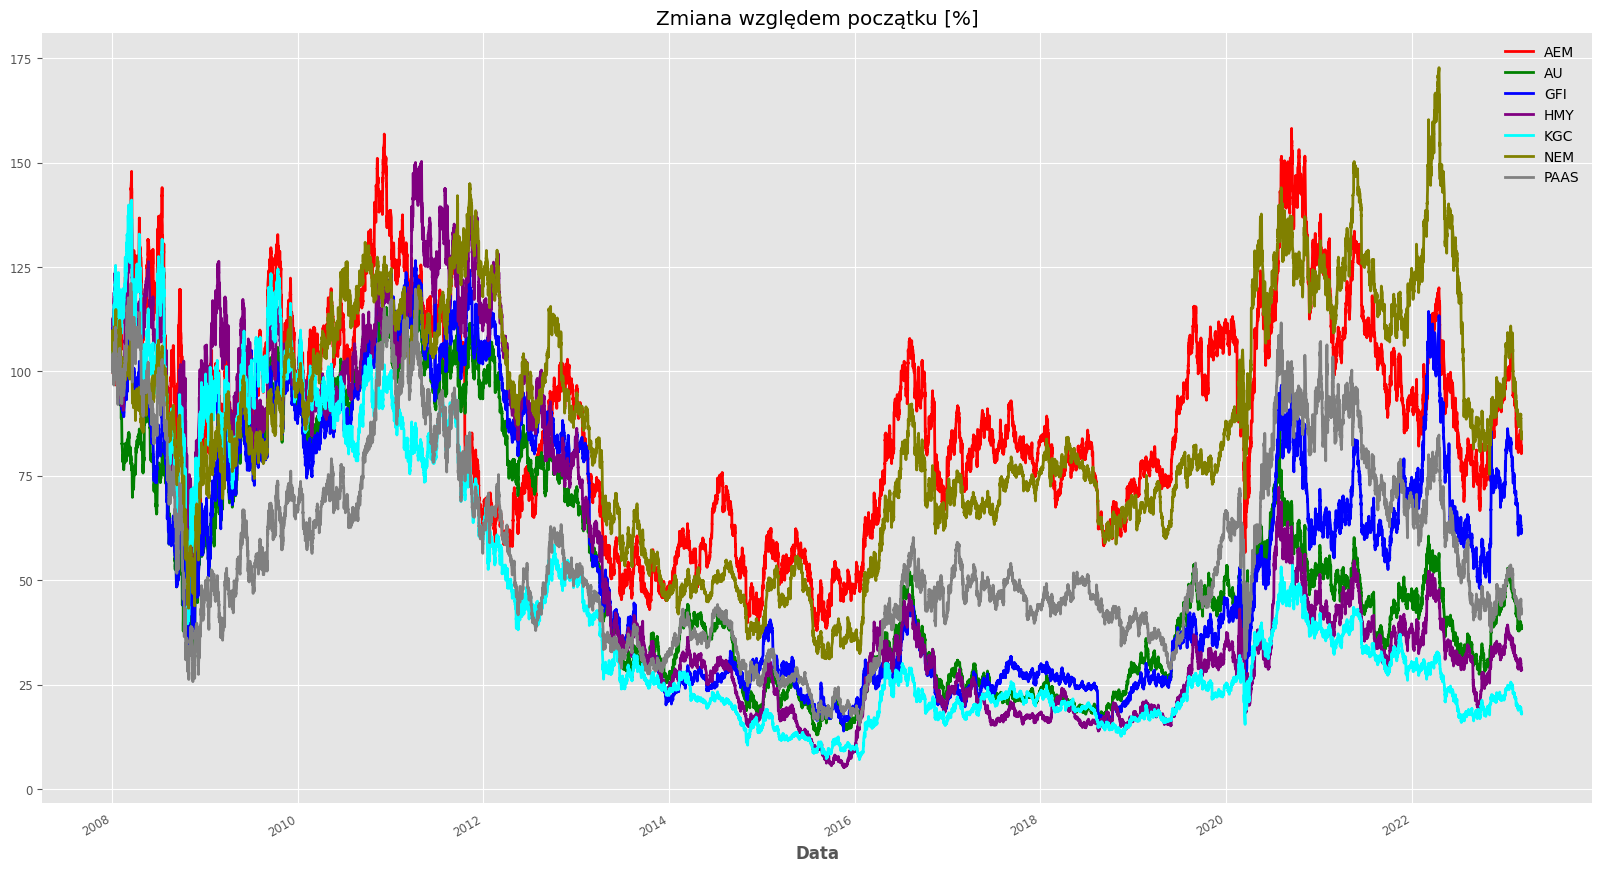

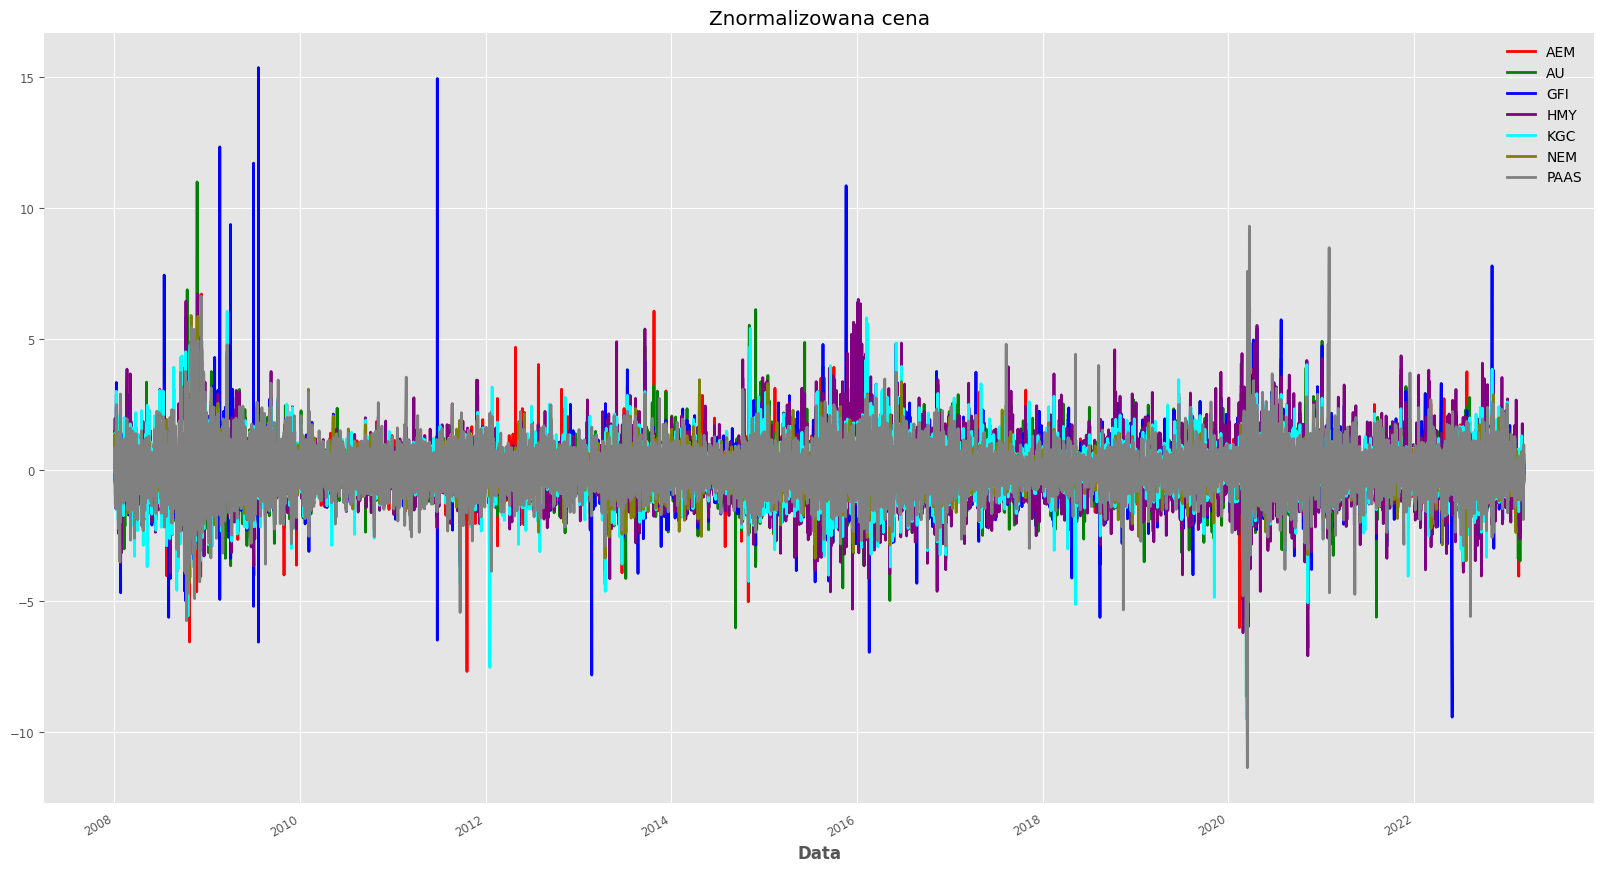

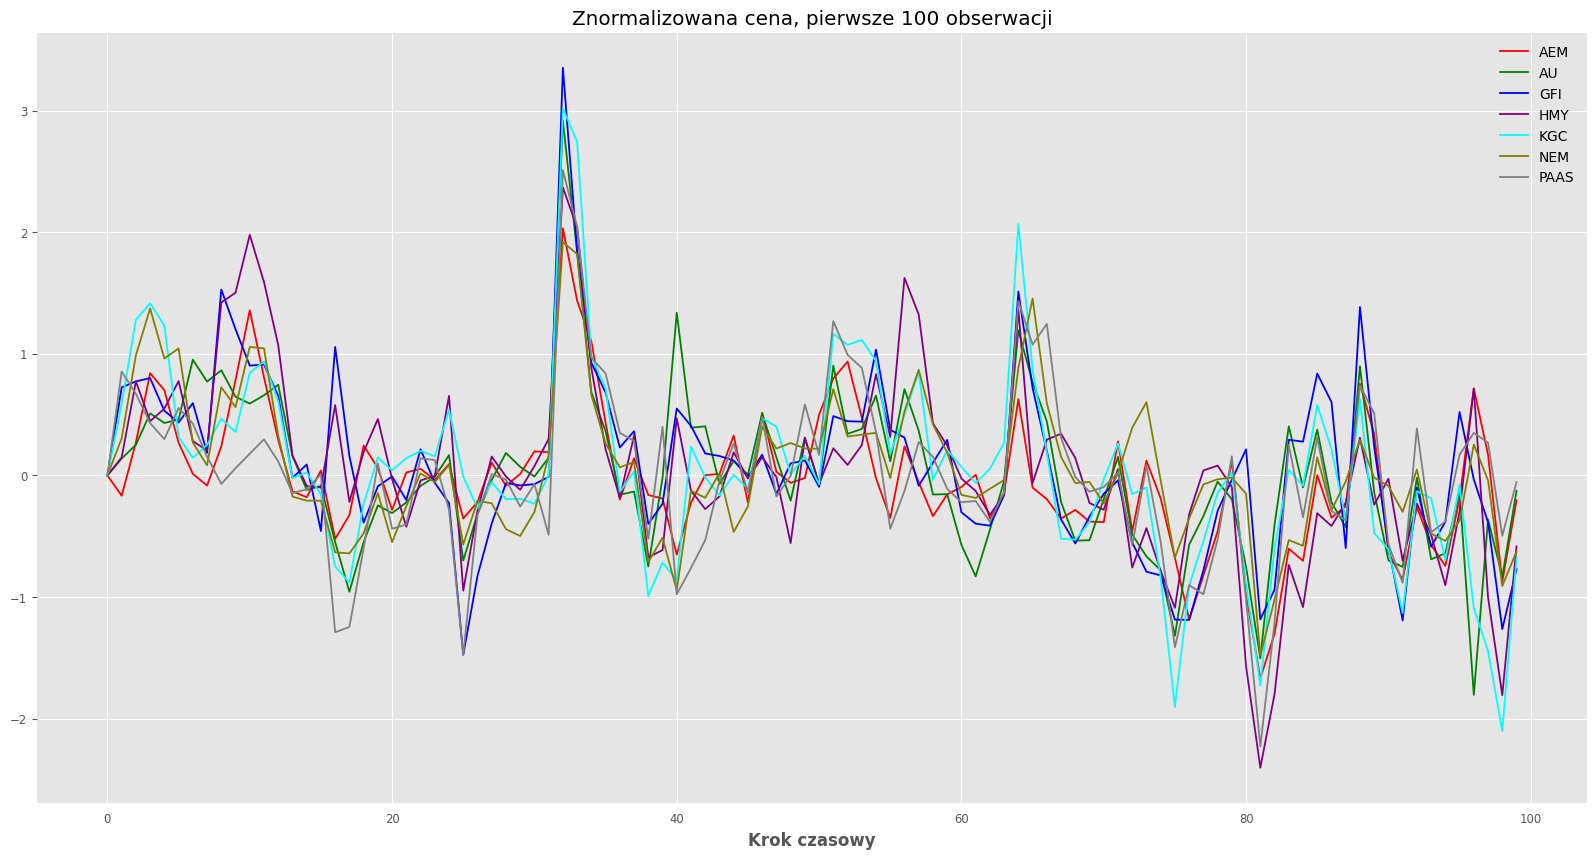

In [21]:
for idx,ticker in enumerate(ds.original.used_tickers):
    ds.original.series[idx].plot(label=ticker,color = COLORS[idx])

plt.title("Cena zamknięcia [$]")
plt.xlabel("Data")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    (100* ds.original.series[idx]/ ds.original.series[idx].first_value()).plot(label=ticker, color = COLORS[idx])
plt.title("Zmiana względem początku [%]")
plt.xlabel("Data")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    ds.transformed.series[idx].plot(label=ticker,color = COLORS[idx])
plt.title("Znormalizowana cena")
plt.xlabel("Data")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.plot(ds.transformed.series[idx][0:100].values(),label=ticker,color = COLORS[idx])
plt.legend(ds.original.used_tickers)
plt.title("Znormalizowana cena, pierwsze 100 obserwacji")
plt.xlabel("Krok czasowy")
plt.show()

In [22]:
my_dict = dict(zip(CONST.TICKERS,[x.pd_series().pct_change().values[1:] * 100 for x in ds.original.train]))
df = pd.DataFrame(my_dict)
df.describe()

KeyboardInterrupt: 

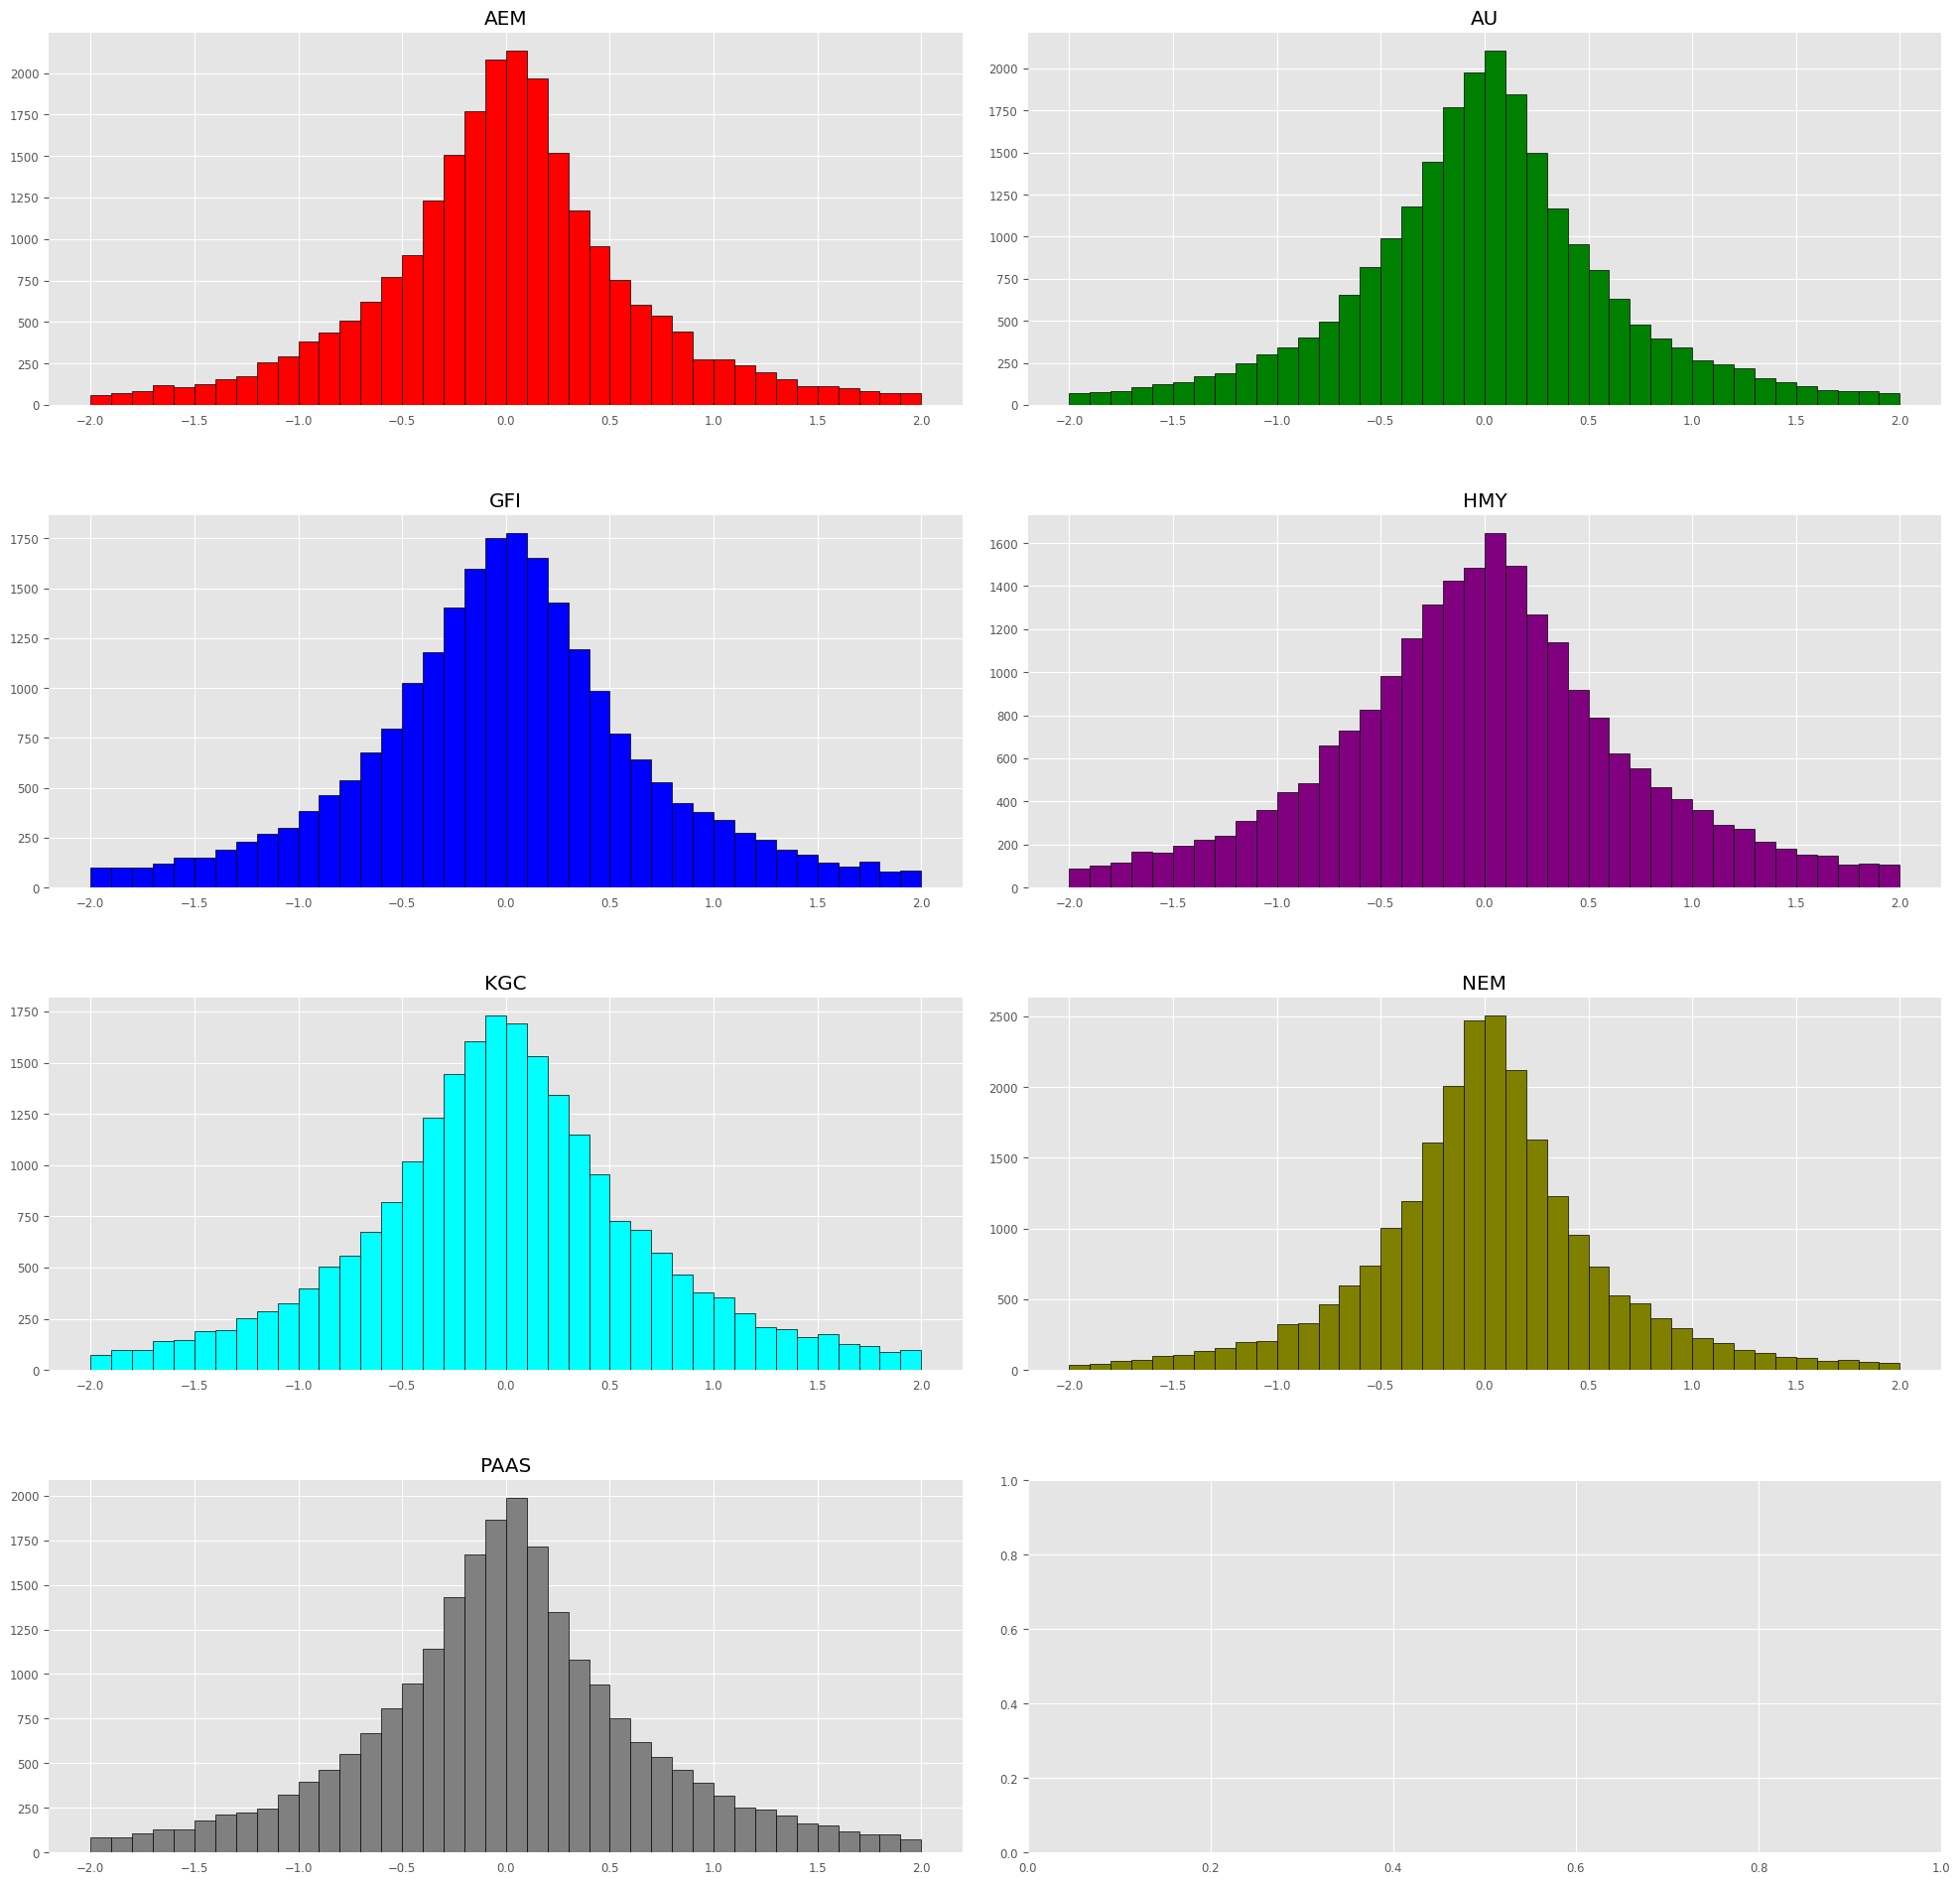

In [ ]:
# Dystrybucja zmian w cenie
bins= [x/10  for x in range(-20,21)]
figure, axis = plt.subplots(4, 2)
figure.tight_layout(pad=2.0)

figure.set_figheight(20)
for idx,ticker in enumerate(df):
    axis[idx // 2, idx % 2].hist(df[ticker], bins= bins, color=COLORS[idx], edgecolor='black')
    axis[idx // 2, idx % 2].set_title(ticker)

plt.show()

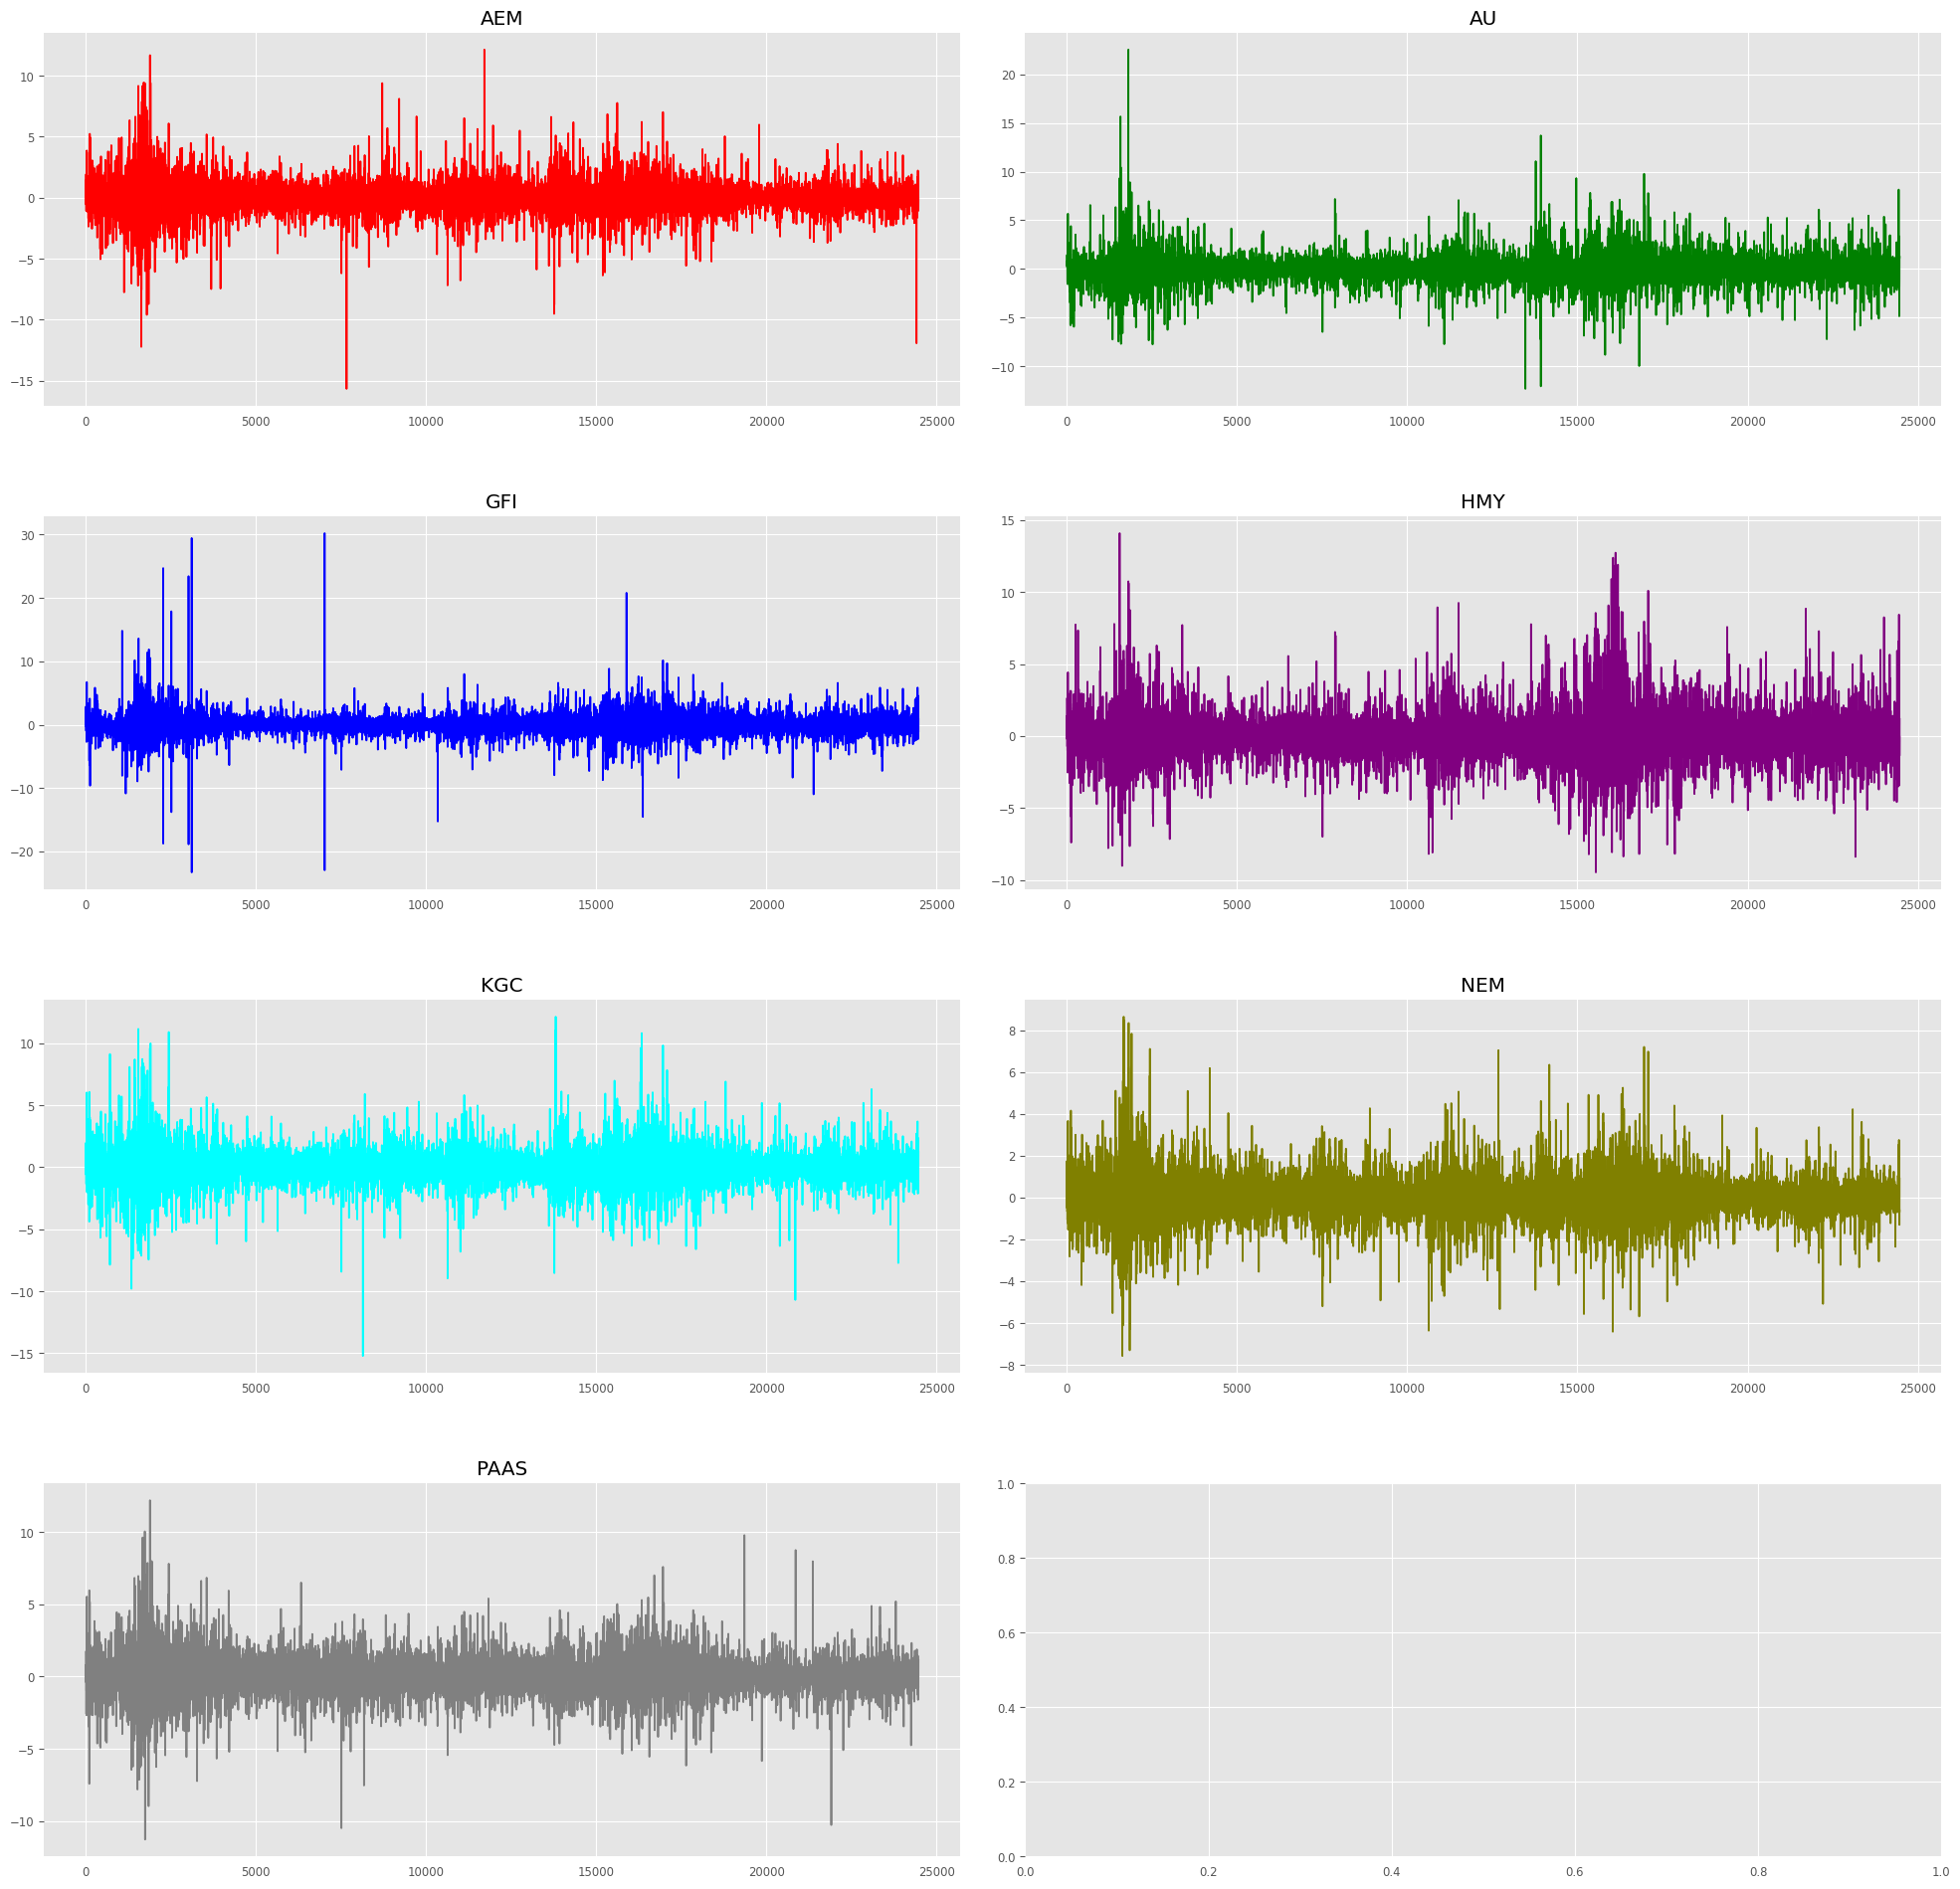

In [ ]:
figure, axis = plt.subplots(4, 2)
figure.tight_layout(pad=2.0)
figure.set_figheight(20)
for idx,ticker in enumerate(df):
    axis[idx // 2, idx % 2].plot(df[ticker], color=COLORS[idx])
    axis[idx // 2, idx % 2].set_title(ticker)

plt.show()

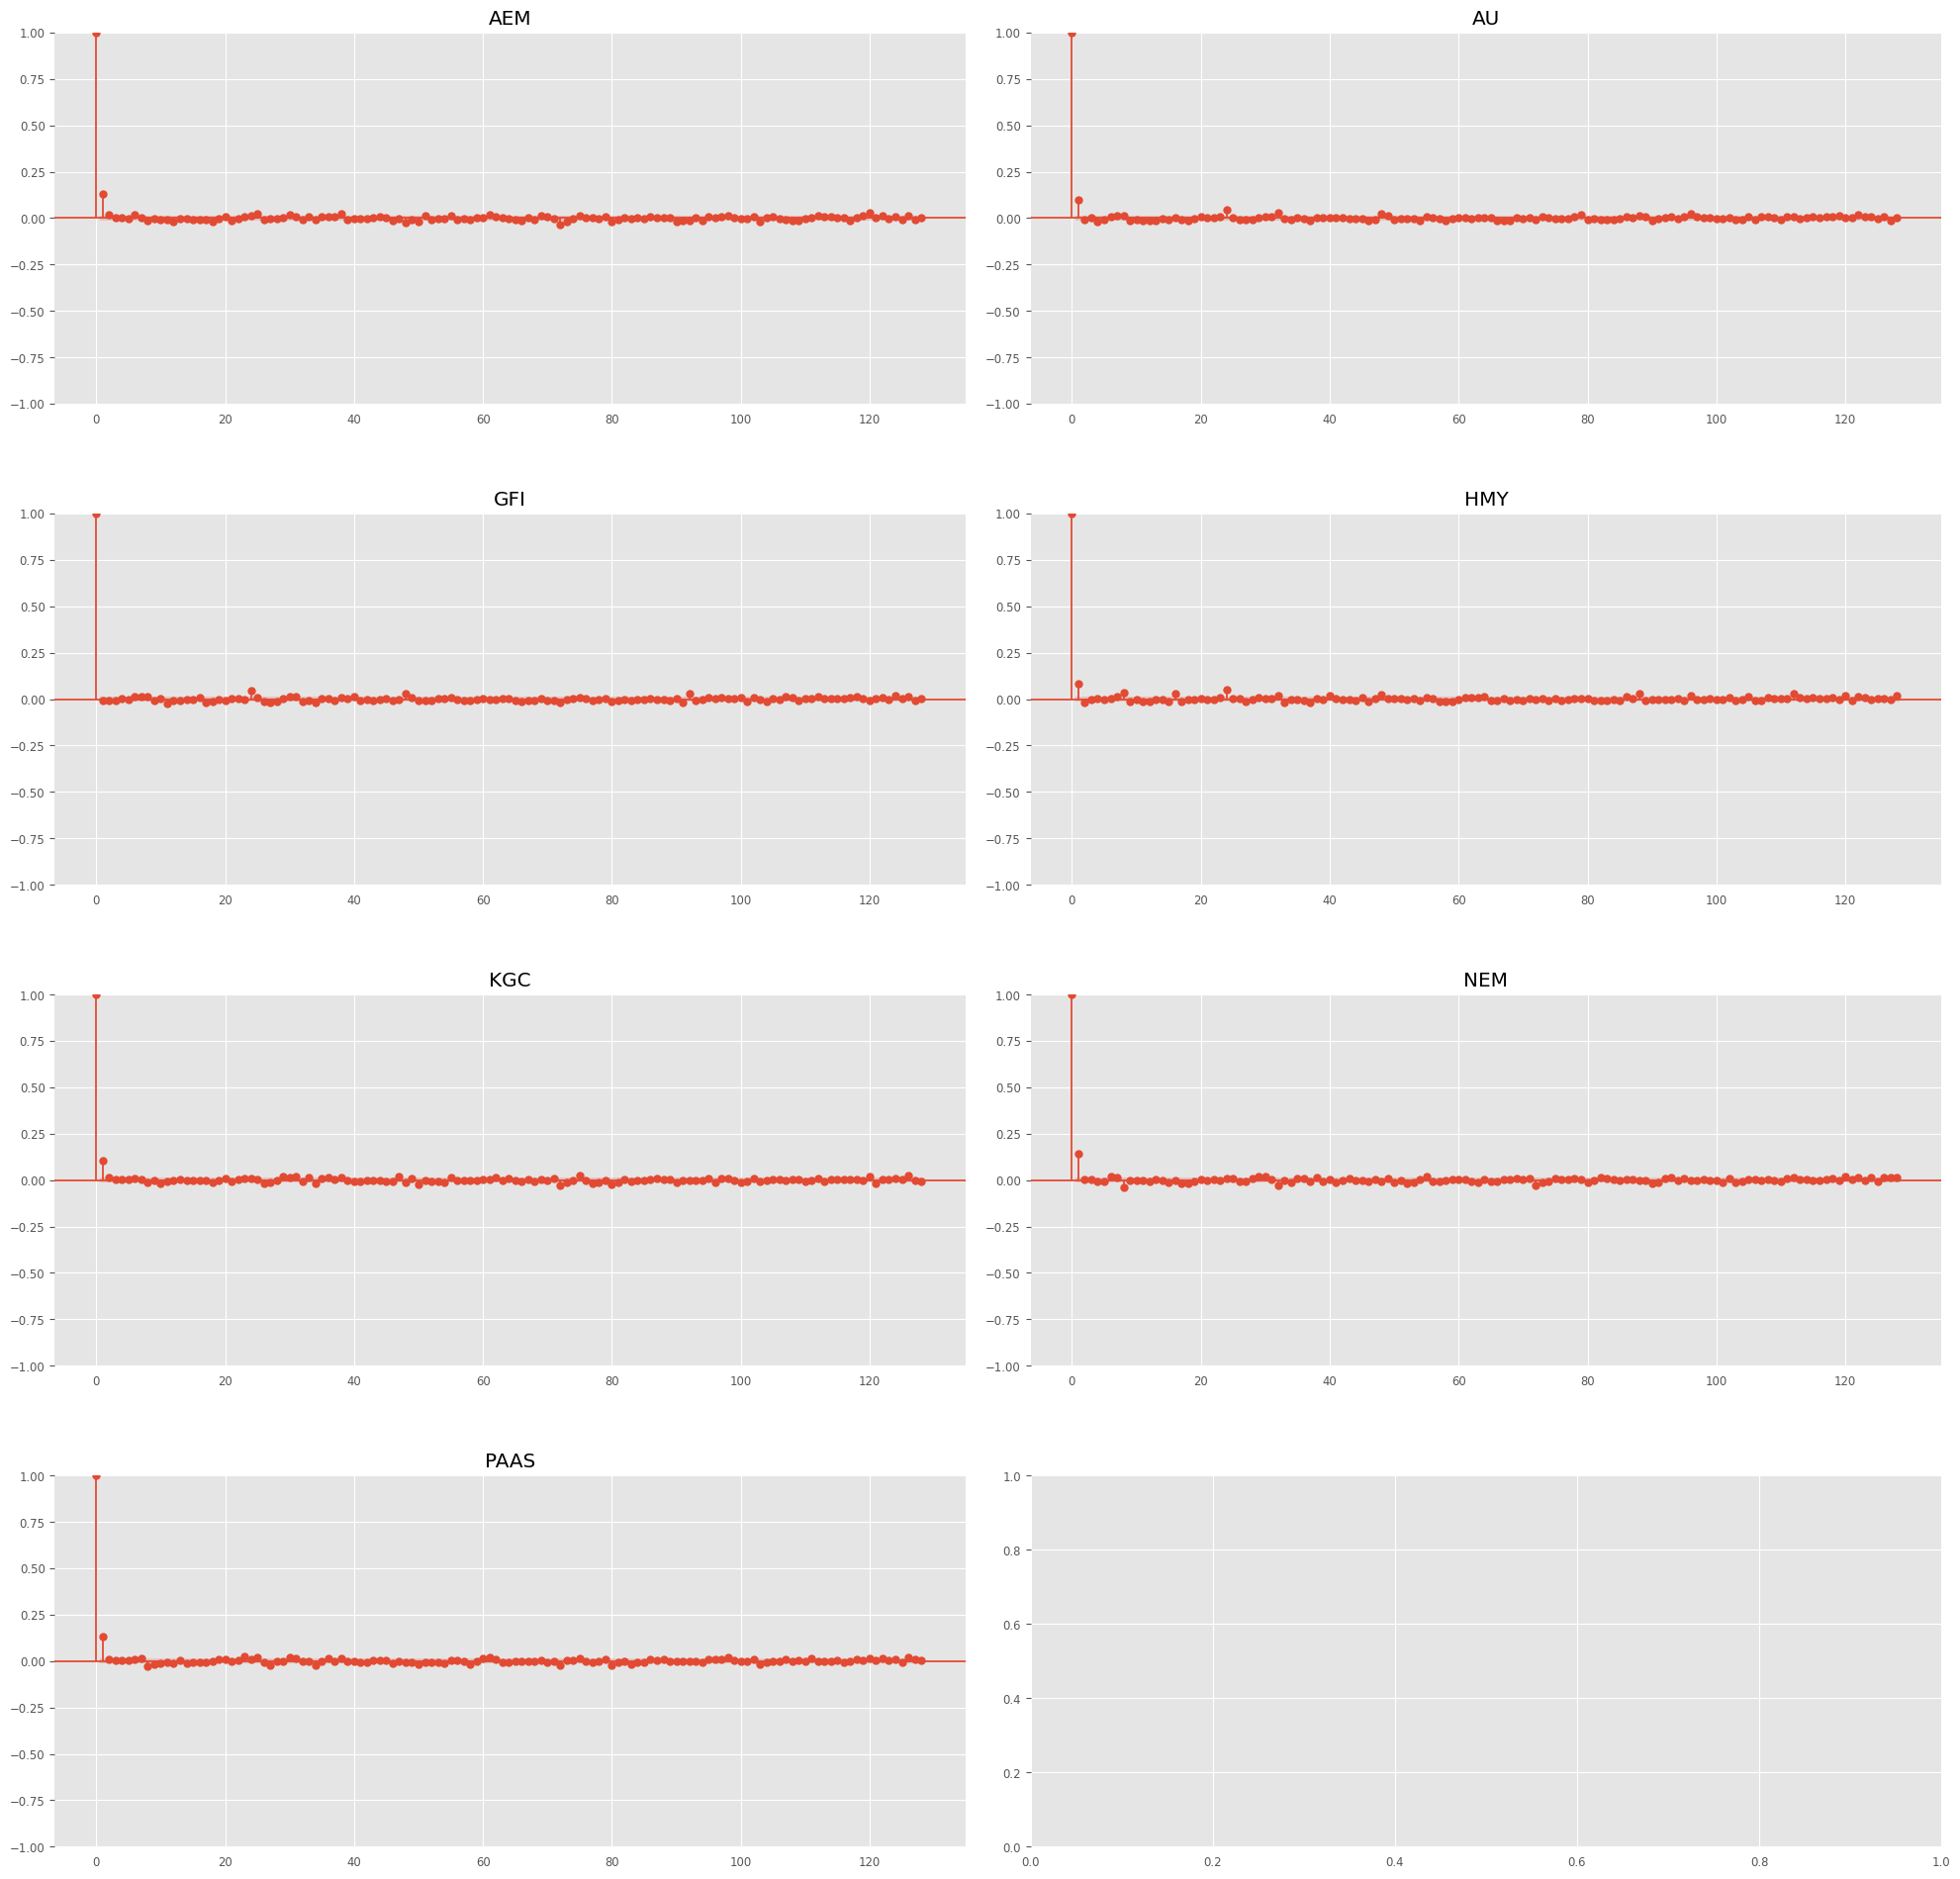

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_from_df(df):
    figure, axis = plt.subplots(4, 2)
    figure.tight_layout(pad=2.0)
    figure.set_figheight(20)
    for idx, ticker in enumerate(df):
        plot_acf(ax= axis[idx // 2, idx % 2],x = df[ticker], lags=128, title=ticker)
    plt.show()

plot_acf_from_df(df)

In [ ]:
import darts.utils.statistics as statistics
# Stationary 
stats_df = pd.DataFrame({ CONST.FEATURES.PRICE: [] })
p_threshold = 0.05
def test_stationarity(timeseries: TimeSeries):
    return statistics.stationarity_test_adf(TimeSeries.from_series(timeseries))[1]

for idx,ticker in enumerate(df):
    price_stationarity = test_stationarity(df[ticker])
    stats_df.loc[ticker] = price_stationarity

print(stats_df)
print(stats_df < p_threshold)

      price
AEM     0.0
AU      0.0
GFI     0.0
HMY     0.0
KGC     0.0
NEM     0.0
PAAS    0.0
      price
AEM    True
AU     True
GFI    True
HMY    True
KGC    True
NEM    True
PAAS   True


In [ ]:
from smoothing import smooth

gold_ts = TimeSeries.from_dataframe(read_csv_ts("data/daily/GOLD.csv")[["adjclose"]])

series = gold_ts[0:100]
plt.plot(range(0,100), series.values(), label=f"α = {1}", color="black")
for i in range (1,10):
    alpha = i / 10
    smoothed = smooth(series, alpha)
    plt.plot(range(0,100), smoothed.values(), label=f"α = {alpha}")


plt.legend(loc="upper right")
plt.show()

KeyError: 'timestamp'

In [ ]:
cov_df = ds.covariates.train[0].pd_dataframe()
cov_df.drop("volume",axis=1, inplace=True)
cov_df

KeyError: "['volume'] not found in axis"

In [ ]:
cov_df.describe()

component,month_sin,month_cos,weekday_sin,weekday_cos,INFLATION,^GSPC,ES=F,GC=F,GOLD,SI=F,SILVER,XLF
count,3.059000e+03,3.059000e+03,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,-1.050278e-03,-1.590722e-03,0.361081,-0.092018,0.561039,0.696043,0.677334,0.679239,0.664923,0.779029,0.726348,0.485987
std,7.073950e-01,7.070472e-01,0.515715,0.771669,0.024358,0.087376,0.076428,0.063246,0.061021,0.050544,0.054580,0.077107
min,-1.000000e+00,-1.000000e+00,-0.433884,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.660254e-01,-6.830127e-01,0.000000,-0.900969,0.561225,0.657385,0.644505,0.647571,0.633573,0.760635,0.706493,0.453450
50%,1.224647e-16,6.123234e-17,0.433884,-0.222521,0.561265,0.705129,0.685393,0.681009,0.666327,0.779395,0.727179,0.490911
75%,5.000000e-01,5.000000e-01,0.781832,0.623490,0.561301,0.744231,0.719442,0.714323,0.698941,0.800191,0.748853,0.525513
max,1.000000e+00,1.000000e+00,0.974928,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_dict = {}
for x,ticker in zip(ds.transformed.train, CONST.TICKERS):
    df_dict[ticker] = x.pd_series()
df_targets = pd.DataFrame.from_dict(df_dict)
df_targets

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
timestamp,,,,,,,
2008-01-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-02 10:00:00,-0.166876,0.139266,0.723964,0.147949,0.587830,0.303600,0.854389
2008-01-02 11:00:00,0.270529,0.251923,0.773202,0.772722,1.279054,0.987467,0.670811
2008-01-02 12:00:00,0.840574,0.510211,0.800271,0.446039,1.416146,1.372055,0.429940
2008-01-02 13:00:00,0.701095,0.431003,0.531379,0.549010,1.232529,0.961349,0.298572
...,...,...,...,...,...,...,...
2020-02-25 15:00:00,-0.504867,-0.919060,-1.184001,-0.586660,-1.017226,-0.827725,-0.739680
2020-02-25 16:00:00,-0.688181,-0.929411,-1.087225,-0.296708,-1.045502,-0.697605,-0.698256
2020-02-26 09:00:00,-0.721620,0.196281,0.441026,0.469227,-0.189849,-0.697187,-0.694947


In [ ]:
df_targets.describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000
mean,0.001389,-0.001106,-0.000615,-0.001348,-0.002791,0.001083,0.000255
std,0.583498,0.612703,0.684252,0.706430,0.645517,0.473671,0.608102
min,-7.675041,-6.012358,-7.810567,-5.296758,-7.523540,-4.286318,-5.740380
25%,-0.243686,-0.264001,-0.283649,-0.338339,-0.288542,-0.203241,-0.272311
50%,0.001634,-0.005815,-0.001964,-0.011880,-0.011192,0.000829,-0.007311
75%,0.238096,0.249950,0.275377,0.310864,0.279887,0.201919,0.269057
max,6.725420,11.002041,15.363012,6.733181,6.068193,5.908979,6.650486


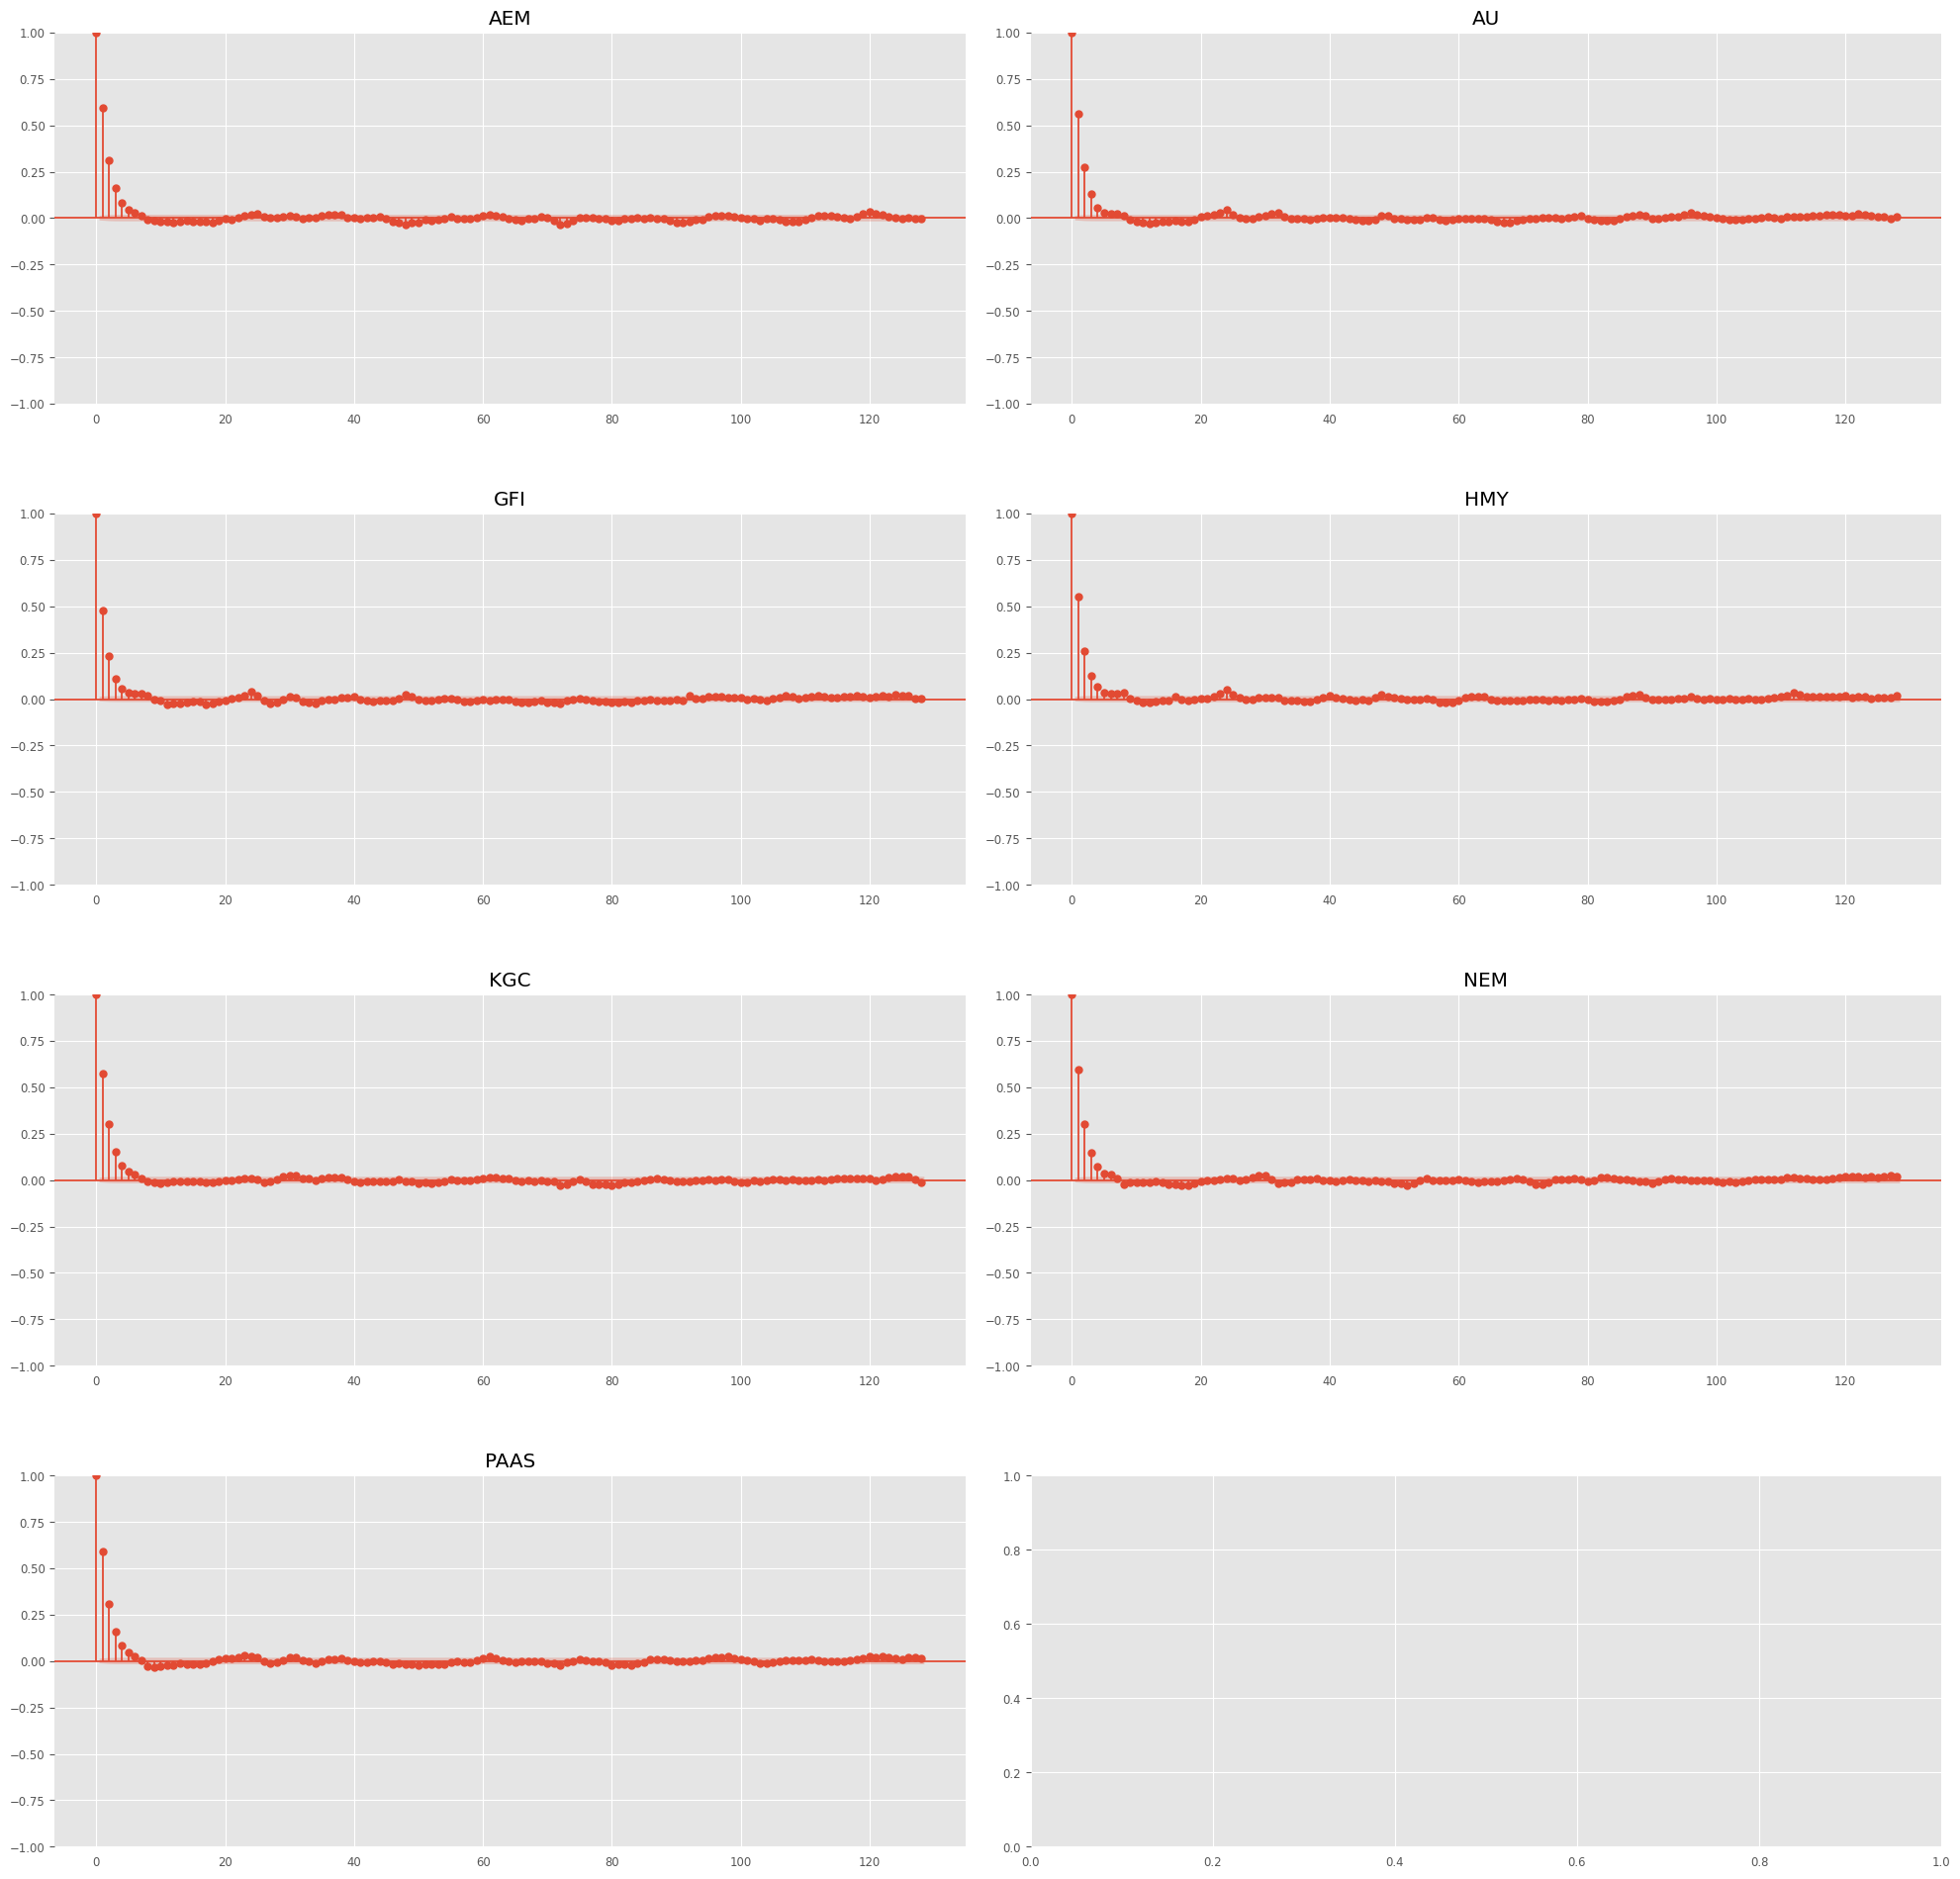

In [ ]:
plot_acf_from_df(df_targets)

In [4]:
df_dict = {}
for x,ticker in zip(ds.original.test, CONST.TICKERS):
    df_dict[ticker] = x.pd_series()
df_test = pd.DataFrame.from_dict(df_dict)
(df_test.pct_change() * 100).describe()

,AEM,AU,GFI,HMY,KGC,NEM,PAAS
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,-0.015213,0.060086,0.077742,0.034337,-0.088022,-0.039837,-0.080785
std,2.522741,2.953805,3.434901,3.790156,2.894144,2.235905,2.916296
min,-7.561183,-8.934480,-23.442627,-10.817301,-10.526323,-13.232154,-15.417462
25%,-1.551361,-1.643874,-1.679841,-2.175930,-1.612259,-1.224318,-1.808608
50%,0.040263,0.000000,0.077534,-0.224268,-0.230208,-0.180584,-0.113001
75%,1.376641,1.514199,1.894853,1.880524,1.695517,1.128599,1.624659
max,8.154047,13.774311,16.575336,16.343487,14.201188,8.795881,9.546864
